# Principal component analysis

PCA is an ingeniously simple mathematical device with many wondrous properties. Unfortunately to properly see the wonder you have to understand a formidable amount of linear algebra.  But because it’s so wondrous it gets used a lot in contexts where the said understanding is missing. And then people like me get asked to explain it a lot. So I’ll try.

One of the purposes of using PCA is dimension reduction. When you measure a large number of variables, two things tend to happen. First, making any sense of it all becomes really difficult. Second, and this is the important part, you actually don’t measure as much information as it seems because of correlation between the variables. And if you have had a look at the mathematical definition, you know that PCA amounts to finding the principal value (eigenvalue) decompostion of the correlation matrix. So we start with correlation

## Correlation

So what is correlation? Forget about formal mathematical definitions, we are handwaving here. Consider this: the correlation between two variables is a measure of *how much or little you get to be surprised when, after measuring the first, you measure the second*. Look at this scatterplot.

In [1]:
# some preliminaries...
library(MASS)
library(ggplot2)
library(dplyr)
data(cats)

catnames <- rep("", times=nrow(cats))
catnames[23] <- "Fluffy"
cats <- mutate(cats, name = catnames)


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



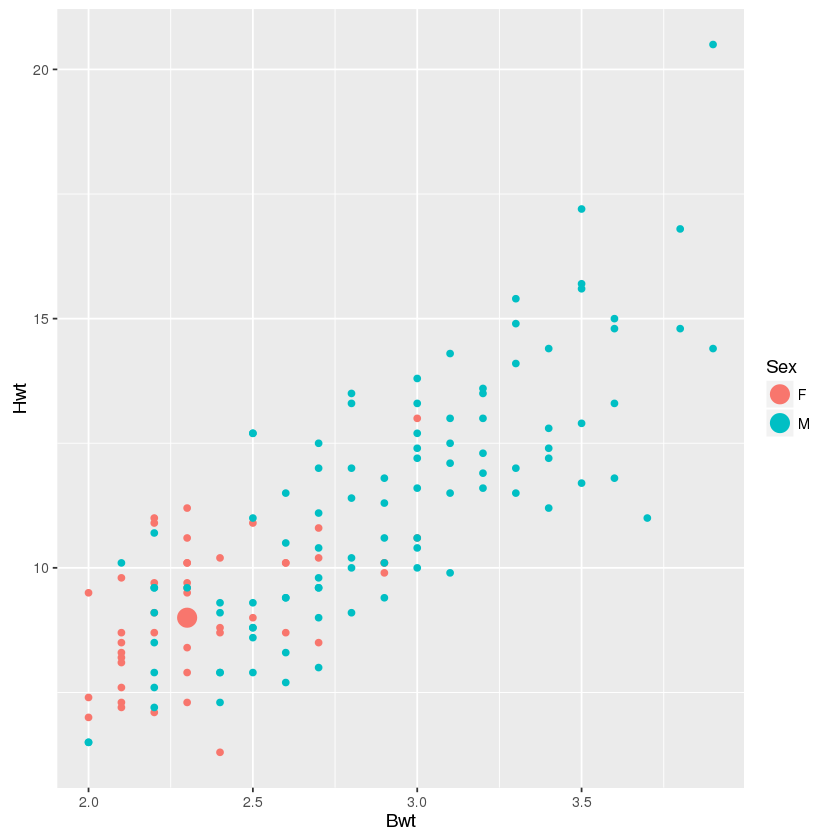

In [2]:
ggplot(cats,aes(Bwt,Hwt,col=Sex)) + geom_point() +geom_point(data=filter(cats,name=="Fluffy"),size=5) 

It has kitties! Kitties with hearts! On x-axis we have cat body weights in kilograms, on y-axis the weights of hearts, in grams. The big circle is Fluffy, who we'll look at more closely.

In [3]:
summary(cats)
filter(cats,name=="Fluffy")

 Sex         Bwt             Hwt            name          
 F:47   Min.   :2.000   Min.   : 6.30   Length:144        
 M:97   1st Qu.:2.300   1st Qu.: 8.95   Class :character  
        Median :2.700   Median :10.10   Mode  :character  
        Mean   :2.724   Mean   :10.63                     
        3rd Qu.:3.025   3rd Qu.:12.12                     
        Max.   :3.900   Max.   :20.50                     

,Sex,Bwt,Hwt,name
1,F,2.3,9,Fluffy


Fluffy weighs 2.3 kilograms. Is that a lot or a little? Kitty weights range from 2 to 3.9, with average of about 2.7. Fluffy's weight is in fact equal to the lower quartile, which means that she's quite clearly on the small side, but not tiny. Her heart weighs 9 grams. Is that a lot? Again, it is roughly the lower quartile, so it's a small heart. Similarly for all the other cats. *BREAKING NEWS:* big cats have big hearts and small cats have small hearts. So imagine you now go and find a new cat, measure it to be rather average in weight, and then you go and weigh its heart (hold on a moment, how exactly does one do that? Do we want to dwell on this?) you already can expect it to be of average weight. No surprise there. Because of correlation. 

In other words, when you are measuring the second variable out of a pair of correlated variables *you are not getting a completely new piece of information*. You are receiving partially old news, the same thing again, which in this kitty case is the size of the cat. It doesn’t matter in which order you take the measurements: you could weigh the heart first and that would still mostly just tell you the size of the cat. When you measure both you get two pieces of information: the size of the cat and whether its heart is particularly large or small for a cat of that size. But **neither measurement tells you the latter directly, while both measurements tell something about the first**.

You can take this idea further. With two strongly correlated variables, you appear to be measuring two variables but in fact you are measuring the same thing twice, just in two different units! Think of measuring amounts of water by measuring both the weight and the volume: two units, two variables, two sets of values, but just one piece of information, the amount of water (and a little bit of noise). In the kitty case the units are both measures of weight but one is grams and the other is kilograms and the ”same thing” they represent is the size of the cat. But since the correlation there isn’t perfect there is also another piece of information received, namely the ”heavyheartedness” of the cat. But you only see it if you look at the disagreement between the measurements, not directly in either.

And that's exactly what PCA does for you, in case of two variables: teases apart those two things so that you can look at them directly. We'll see the result very soon but, first a detour to scaling, which is usually done silently and automatically before the PCA is even started.

## Scaling

I claimed above that both the cat's bodyweight and heartweight measure essentially the same thing, the cat's size. It's easy to accept, since they both are measures of weight but I also claimed that totally different kinds of measurements can also measure the same quantity. In order to be able to compare how much two measurements agree and disagree you need to have them on the same *scale*, to be expressed in same units. Impossible? Not at all: there is a way to make *anything* be measured in the same scale, as long as you have many experimental units measured.

This magic trick is called scaling, appropriately, and sometimes also standardizing. Mathematically it means this:

$$
z_i = \frac{x_i -\mu}{\sigma}
$$

where $\mu$ is the mean of the $x_i$ values, and $\sigma$ is their standard deviation. The result is that tha original values are expressed as **so and so many standard deviations above or below the mean**. This way, any measurements can be directly compared: if they get the same scaled value, it means they are equally extreme, on that side of the corresponding distribution.

We can now do this to the kitties:

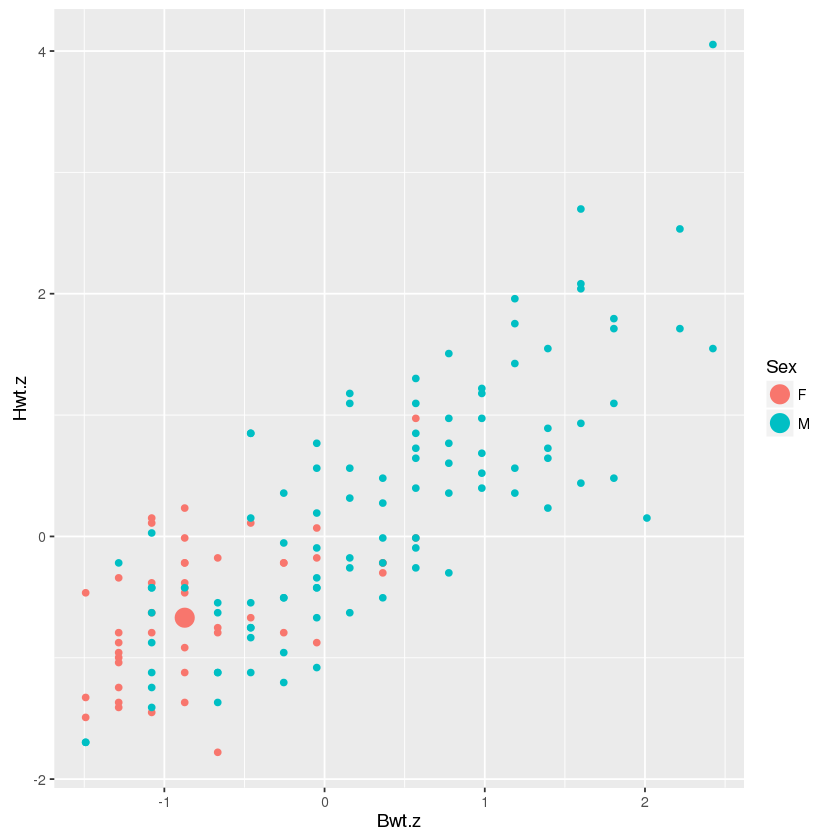

In [4]:
cats.z <- as.data.frame(cats %>% select(Bwt,Hwt) %>% scale()) %>% 
    rename(Bwt.z=Bwt,Hwt.z=Hwt)  %>% 
    bind_cols(cats)

ggplot(cats.z,aes(Bwt.z,Hwt.z,col=Sex)) + geom_point() +geom_point(data=filter(cats.z,name=="Fluffy"),size=5) 

In [5]:
filter(cats.z,name=="Fluffy")

,Bwt.z,Hwt.z,Sex,Bwt,Hwt,name
1,-0.872873102941368,-0.669732845142986,F,2.3,9,Fluffy


You should notice that only the scales of the axes changed in the scatterplot, the point cloud looks exactly like before. This is exactly as it should be: we didn't touch the data at all, only the scale it was measured in. Additionaly, when we look at Fluffy again, we see that indeed, she's a slightly small kitty, roughly 0.9 standard deviations below the mean. Also her heart is on the small side but now we can in fact see that her heart is "less small" than you'd expect for such a small cat, being only 0.7 standard deviations below the mean. Or, equivalently, the other way around: that Fluffy *weighs less than you'd expect for a cat with a heart of that weight*. In summary, Fluffy is a bit heavyhearted.
Now let's look at the result of PCA.

## PCA transformation in 2-d: loadings

Importance of components:
                          Comp.1     Comp.2
Standard deviation     1.3385062 0.44103554
Proportion of Variance 0.9020637 0.09793629
Cumulative Proportion  0.9020637 1.00000000


Loadings:
      Comp.1 Comp.2
Bwt.z -0.707  0.707
Hwt.z -0.707 -0.707

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

,Bwt.z,Hwt.z,Sex,Bwt,Hwt,name,Comp.1,Comp.2
1,-0.872873102941368,-0.669732845142986,F,2.3,9,Fluffy,1.09078712658915,-0.14364185382122


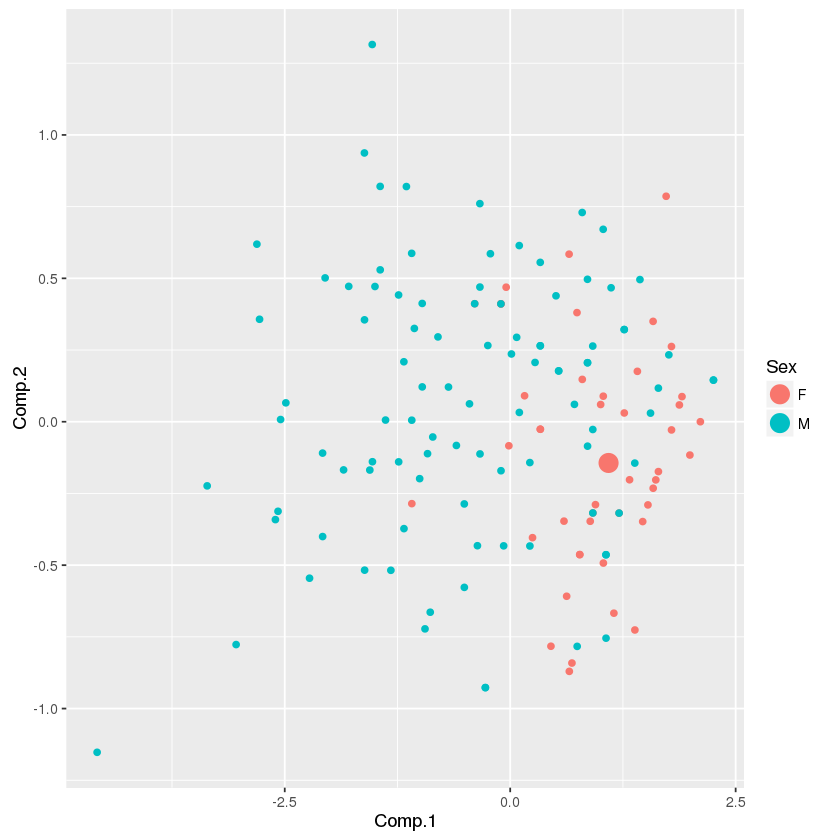

In [6]:
pca <- princomp(~Bwt.z+Hwt.z, cats.z, scores = TRUE)
summary(pca)
loadings(pca)
cats.pca <- bind_cols(cats.z,as.data.frame(pca$scores))
ggplot(cats.pca,aes(Comp.1,Comp.2,col=Sex)) + geom_point() +geom_point(data=filter(cats.pca,name=="Fluffy"),size=5)
filter(cats.pca,name=="Fluffy")

There's a lot to see now. First look at the scatterplot. It shows those two principal components and each cat is still a point in those two dimensions. The scale is in fact also the same as before the PCA transformation: so and so many standard deviations below or above the mean. (How do you know? Keep reading.) But the variable measured, what is that? This is what we wanted to know!

That is shown in the **loadings matrix: the principal components are the original (scaled) variables multiplied with those values, then summed**. If you've heard the mathy explanation, this is the **linear combination** of the original variables,  that it speaks of (and it is actually done as a matrix multiplication, should you know what that means). For Fluffy in particular:

In [7]:
fluffy <- filter(cats.pca,name=="Fluffy") %>% select(Bwt.z,Hwt.z) %>% as.vector()
fluffy
Lmat <- loadings(pca)
Lmat
sum(fluffy * Lmat[,1])
sum(fluffy * Lmat[,2])
filter(cats.pca, name=="Fluffy") %>% select(Comp.1, Comp.2)

,Bwt.z,Hwt.z
1,-0.8728731,-0.6697328



Loadings:
      Comp.1 Comp.2
Bwt.z -0.707  0.707
Hwt.z -0.707 -0.707

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

[1] 1.090787

[1] -0.1436419

,Comp.1,Comp.2
1,1.0907871,-0.1436419


In other words, the first component is a sum in equal weight of the two original measures, the second component is their difference in equal weight. The "same", and the "disagreement". 

(Why exactly those weights, 0.7 and so? To keep the new variables at the same scale as before, as  claimed earlier. It's actually $\frac{1}{\sqrt{2}}$. Two of those squared and summed makes 1. Mathematical detail.) 

It so happens that the result of PCA in two dimensions is *always* this: the same and the disagreement, or in other words, the loadings matrix is always the same... up to a couple of changes. The first possible change is a technical triviality, but potentially confusing: the **sign** of the loadings can flip. In other words they could be plus *or* minus 0.7 *both* for the first component, and plus *and* minus 0.7 *in either order* for the second.

In fact, for (very) technical reasons I can't be sure which one showed up in this document! But I do know that the first component can be called the *size* of the cat and that Fluffy is somewhat small, size about 1 s.d. away from the mean. I just don't know to which direction, or in other words whether the size is *smallness* (negative -0.7, Fluffy above the mean) or *largeness* (positive 0.7, Fluffy below the mean). I also know that Fluffy is slightly heavyhearted, 0.1 s.d. away from the mean, but again, whether the component is showing *heavy- or lightheartedness* I can't be sure.

The second change that can happen in general for two-dimensional PCA is the **order**: the "disagreement" could be the first component and the "same" the second. That one isn't up to technical chance though: it depends on the sign of the correlation which I know to be positive in this kitty case. This point leads us to the next topic.

Before moving on to that, if you are reading this document in interactive mode you can go back to the christening of the cat 23 as Fluffy, back in the first code cell and pick another cat (another number between 1 and 144) to play the part. The text won't change, but all the code results will.

## Order and importance of the components, 2-d

See this part of the pca result again:

In [8]:
summary(pca)

Importance of components:
                          Comp.1     Comp.2
Standard deviation     1.3385062 0.44103554
Proportion of Variance 0.9020637 0.09793629
Cumulative Proportion  0.9020637 1.00000000

We will now look at the "proportion of variance" for the two components. I explained above that when two highly correlated variables are measured, in practice only one piece of information is obtained. When PCA takes apart the "same" and the "disagreement" in 2-d it also takes note of the **proportion** in which the information in the two original ones is made of those. The component that captures more of the information gets to be called the first, the other the second, and that proportion is exactly what is shown in the output. We will look at more than two dimensions soon where things get a bit more complicated and interesting but to explore this connection of 2-d correlation, let's play with a simulation.

Importance of components:
                          Comp.1     Comp.2
Standard deviation     1.3781864 0.31717875
Proportion of Variance 0.9496988 0.05030118
Cumulative Proportion  0.9496988 1.00000000


Loadings:
   Comp.1 Comp.2
X1 -0.707 -0.707
X2  0.707 -0.707

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

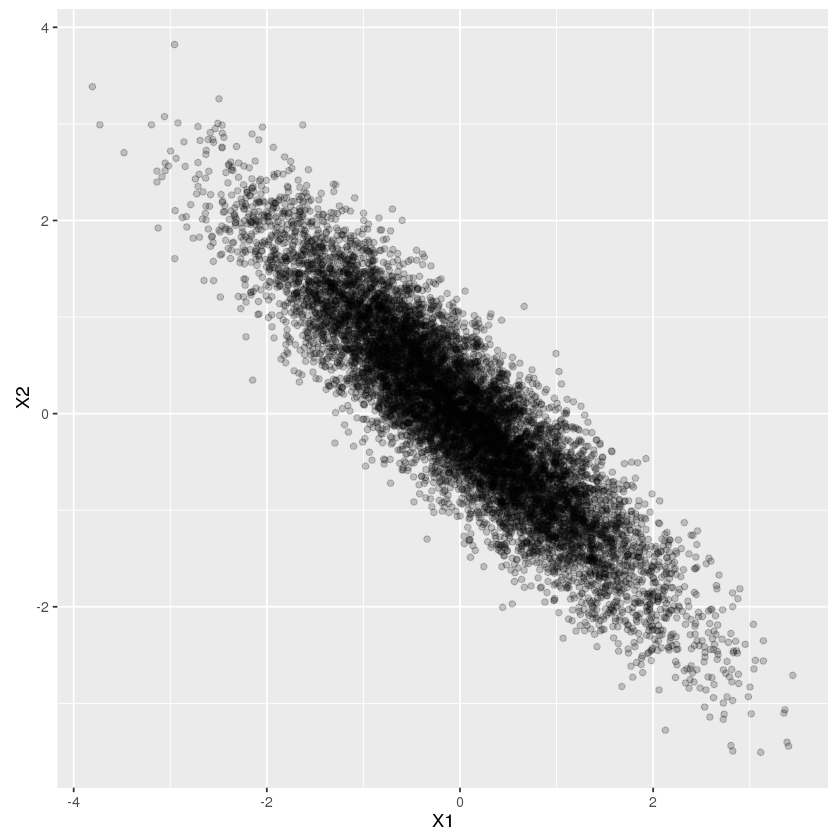

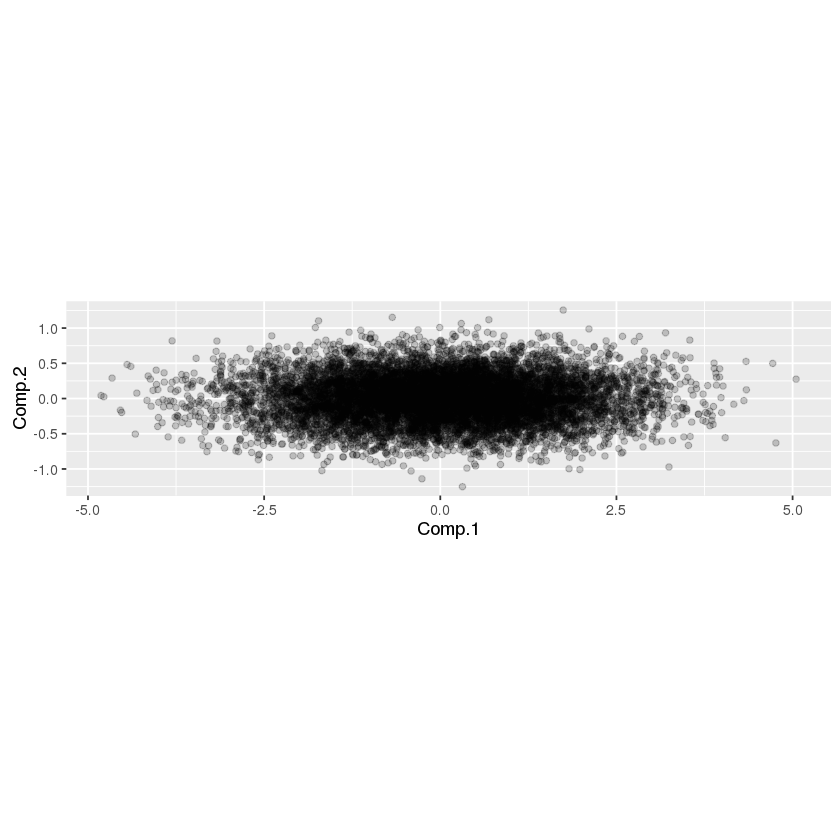

In [27]:
#install.packages("mvtnorm") #if needed
library(mvtnorm)

corr <- -0.9 #change this to anything between -1 and 1 (non-inclusive)

X <- data.frame(rmvnorm(10000, c(0,0), matrix(c(1, corr, corr, 1), ncol=2)))

ggplot(X,aes(X1,X2)) +geom_point(alpha=0.2) + coord_fixed()

pca.sim <- princomp(~X1+X2, X, cor=TRUE, scores=TRUE)
summary(pca.sim)
loadings(pca.sim)
ggplot(data.frame(pca.sim$scores),aes(Comp.1,Comp.2)) + geom_point(alpha=0.2) + coord_fixed()

This piece of code is trying to make the following things clear:
- the higher the correlation is, regardless of its sign, the higher the proportion of variance is that the first component captures
- when there's no correlation, the variance proportion is equal - one half - between the components
- when the correlation is negative, the "disagreement" captures more of the variation and becomes the first component
- the shape of the point cloud of the principal components is the same as of the original point cloud, just rotated (and possibly flipped) (but only shows if you force the axes to be drawn at a common aspect ratio)

This last point gets often emphasized when PCA is explained. It is true of course, and again, if one understands the linear algebra behind PCA it makes a lot of sense. (Mathematical detail: the loadings matrix is a rotation matrix.) But in my opinion that isn't a very useful point when you try to understand and interpret the components. But the ideas of "most of the variation" and the shape of the point cloud *are* graphically linked: the first component captures **most of the variance** in the original data and that also makes it correspond to **the axis of the point cloud ellipse which is longest**. The proportions of the principal components map directly to the lengths of those axes. The more correlation there is, the more squeezed out the point cloud is, and the longer the long axis is. And the less information there is in the other component.

## PCA in 5 dimensions

We will now look at people instead of cats.

,Age,Pulse,Height,Wr.Hnd,NW.Hnd
Age,1.00000000,-0.12118904,-0.02603625,0.08555953,0.11552080
Pulse,-0.121189036,1.000000000,-0.084683735,-0.007608736,-0.016978286
Height,-0.02603625,-0.08468373,1.00000000,0.61835354,0.59996337
Wr.Hnd,0.085559532,-0.007608736,0.618353536,1.000000000,0.966431491
NW.Hnd,0.11552080,-0.01697829,0.59996337,0.96643149,1.00000000


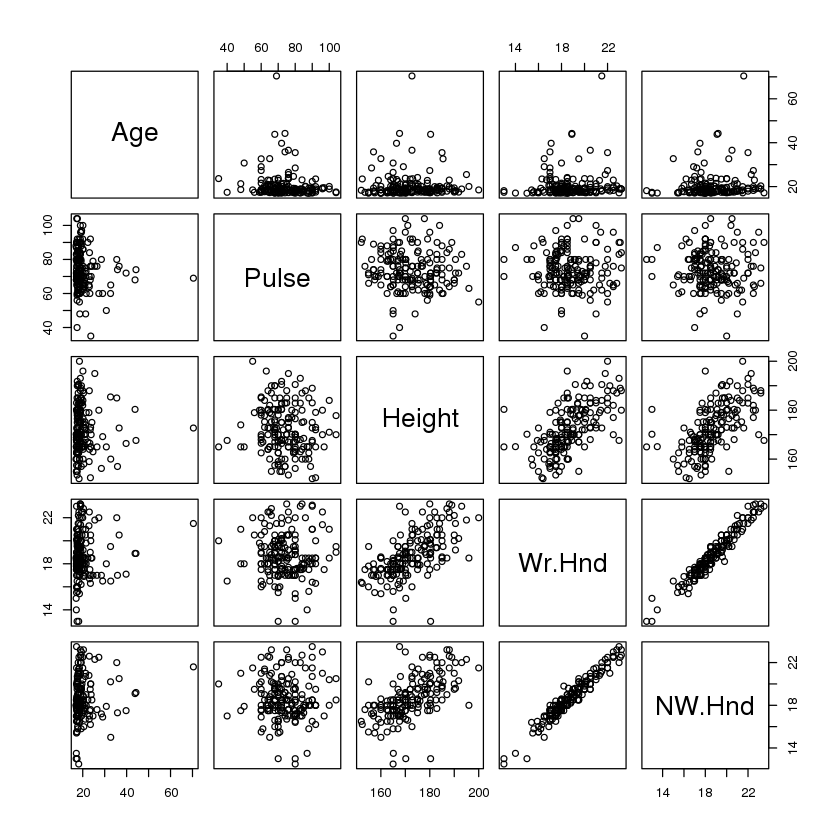

In [33]:
data(survey)
people <- survey %>% select(Age, Pulse, Height, Wr.Hnd, NW.Hnd) %>% na.omit()
cor(people)
pairs(people)

These are measurements of (or rather, answers given by) participants of a statistics course: their age, pulse rate, height in cm, and the distance from tip of thumb to tip of little finger of spread hand, both in their writing and non-writing hand. The pairwise scatterplots tell us roughly the same thing as the correlation matrix:
- people's writing and non-writing hands are very closely the same size but not quite exactly
- taller people have larger hands
- older people aren't generally taller... because these people are all adults
- pulse appears to have a little something to do with body size and age

Let's plunge right in to the results of PCA on this data set: 

In [39]:
pca.people <- princomp(~., people, cor=TRUE)
summary(pca.people)
loadings(pca.people)

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4      Comp.5
Standard deviation     1.5754694 1.0545221 0.9531837 0.68151770 0.181256277
Proportion of Variance 0.4964208 0.2224034 0.1817118 0.09289328 0.006570768
Cumulative Proportion  0.4964208 0.7188241 0.9005360 0.99342923 1.000000000


Loadings:
       Comp.1 Comp.2 Comp.3 Comp.4 Comp.5
Age            0.707  0.671 -0.209       
Pulse         -0.701  0.693 -0.162       
Height -0.501        -0.236 -0.829       
Wr.Hnd -0.610                0.337 -0.712
NW.Hnd -0.607                0.361  0.702

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5
SS loadings       1.0    1.0    1.0    1.0    1.0
Proportion Var    0.2    0.2    0.2    0.2    0.2
Cumulative Var    0.2    0.4    0.6    0.8    1.0

First, about the loadings. (Note that for ease of reading the default output of loadings doesn't show the values that are close to 0 at all.) This is not an exact science, but what you should be looking at is which original variables show up with large weights, and then if they have the same sign ("sameness") and which show up with opposite signs ("disagreement"). Here's my take: 
- As first component we get a roughly equal mix of the size measurements, so again we can call this component size. 
- The second one is a disagreement between the age and pulse: you get high on this dimension if you are older and your pulse is lower than average. Not quite as easy to interpret, but it perhaps has something to do with physical fitness. 
- The third is puzzling. 
- The fourth is "small / large handedness": it is mostly a disagreement between height and the size of hands
- The fifth is easy: hand asymmetry

Then the importance of the components. The first component gets 50% of the variation. Together with the interpretation of the loadings, this means that for the most part the students differ in size. The cumulative proportion of variance goes up to 90% by the third component. This means that **the five measurements contained information worth only three measurements**. We can, if we wish, **reduce the dimension** of this data from five to three, without losing much of anything. Or even down to two and keep almost three quarters of the information. ***This is one of the main motivations of PCA!***

## Finding subgroups
